# Making Figure 1

In [1]:
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
# set up plotting settings for dark mode.
from jupyterthemes import jtplot
jtplot.style(theme="grade3", context="notebook", ticks=True, grid=False)
from src.plot_utils import ps_defaults, add_units
ps_defaults(use_tex=False, dpi=150)

In [36]:
from src.constants import (
    ERSSTV5_PATH,
    NOAA_DATA_PATH,
    cmip6_ensemble_var,
    cmip6_mmm_mean,
    cmip6_mmm_trend,
    atmos_input_file_path,
)
from src.plot_utils import label_subplots, cmap
from src.xr_utils import can_coords, sel, get_trend, spatial_mean, clip
from src.data_loading.pangeo import load_mfds

ImportError: cannot import name 'plot_nino' from partially initialized module 'src.visualisation.nino' (most likely due to a circular import) (/home/users/sithom/seager19/src/visualisation/nino.py)

In [42]:
from typing import Tuple, Optional
from src.constants import SEL_DICT
import matplotlib

def _get_points(reg_dict: dict) -> Tuple[list]:
    """Get the rectangle from the reg_dict."""
    x, y = [], []
    x.append(reg_dict["X"][0])
    y.append(reg_dict["Y"][0])
    x.append(reg_dict["X"][0])
    y.append(reg_dict["Y"][1])
    x.append(reg_dict["X"][1])
    y.append(reg_dict["Y"][1])
    x.append(reg_dict["X"][1])
    y.append(reg_dict["Y"][0])
    x.append(reg_dict["X"][0])
    y.append(reg_dict["Y"][0])
    return x, y


def plot_nino_box(
    ax: matplotlib.axes.Axes, reg: str, color: Optional[str] = None
) -> None:
    """
    Plot a nino box.

    Args:
        ax (matplotlib.axes.Axes): axis to plot to.
        reg (str): region to plot
        color (Optional[str], optional): Override color option. Defaults to None.
    """
    x, y = _get_points(SEL_DICT[reg])
    if color is None:
        color = SEL_DICT[reg]["color"]
    ax.plot(x, y, label=reg, alpha=0.5, linewidth=2, color=color)

In [6]:
?load_mfds

# Pacific MMM bias

In [6]:
cmip6_ts_trend = xr.open_dataarray(cmip6_mmm_trend("ts"))

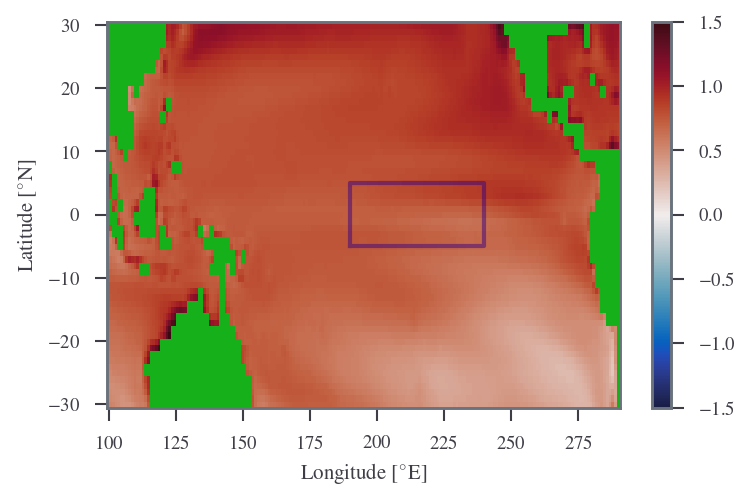

In [43]:
clip(cmip6_ts_trend).plot(cmap=cmap("delta"), vmin=-1.5, vmax=1.5)
ax = plt.gca()
plot_nino_box(
    ax, reg="nino3.4", color=None
)


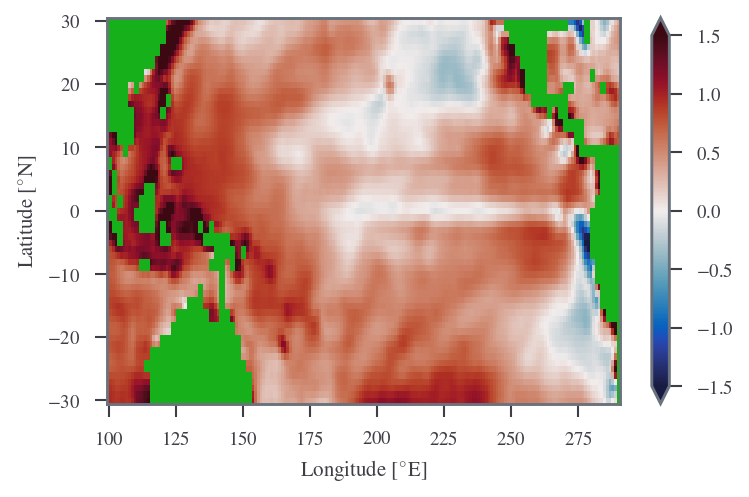

In [29]:
clip(ecmwf_ts_trend).plot(cmap=cmap("delta"), vmin=-1.5, vmax=1.5)

In [7]:
ecmwf_ts_trend = can_coords(xr.open_dataarray(atmos_input_file_path(ending="trend")))

In [8]:
cmip6_ts_trend_bias = cmip6_ts_trend - ecmwf_ts_trend

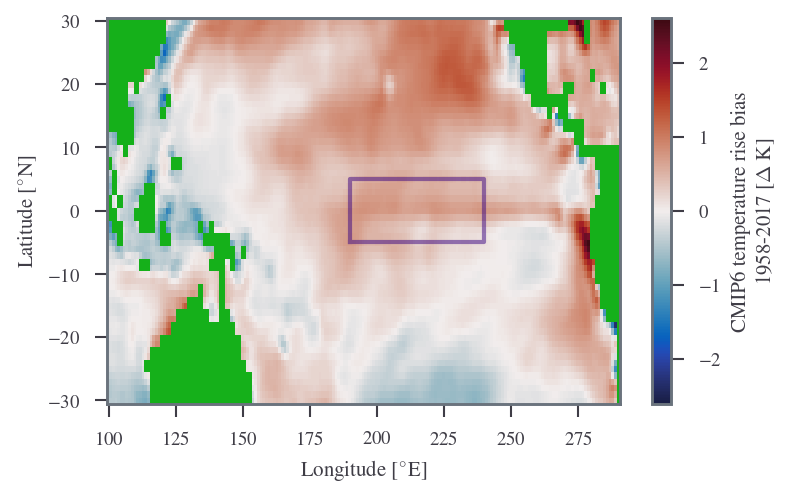

In [44]:
cmip6_ts_trend_bias = clip(add_units(cmip6_ts_trend_bias))
cmip6_ts_trend_bias.attrs["units"] = r"$\Delta$ K"
# cmip6_ts_trend_bias.attrs["long_name"] = "Temperature rise bias $ \Delta ^\circ$C"
cmip6_ts_trend_bias.attrs["long_name"] = "CMIP6 temperature rise bias 1958-2017"

cmip6_ts_trend_bias.plot(cmap=cmap("delta"))
ax = plt.gca()
plot_nino_box(
    ax, reg="nino3.4", color=None
)

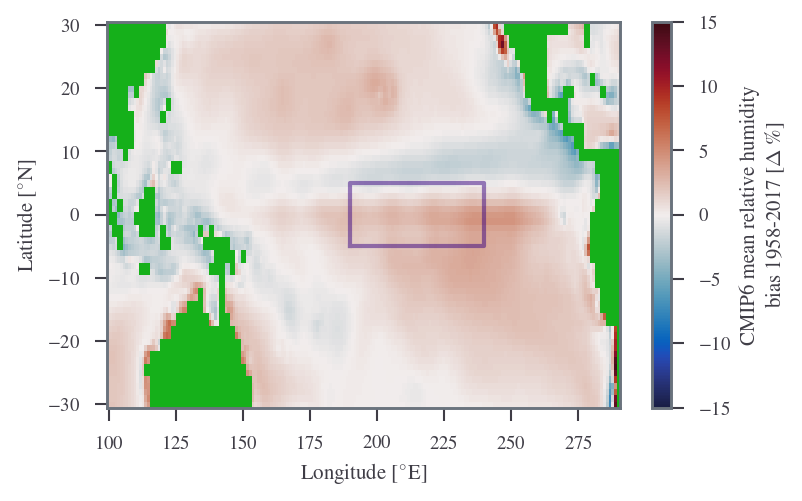

In [56]:
cmip6_rh_mean = xr.open_dataarray(cmip6_mmm_mean("hurs"))
ecmwf_rh_mean = can_coords(xr.open_dataarray(atmos_input_file_path(var="rh", ending="clim60")))
cmip6_rh_mean_bias = cmip6_rh_mean.sel(Y=slice(-60, 60)) - ecmwf_rh_mean
cmip6_rh_mean_bias = clip(add_units(cmip6_rh_mean_bias))
cmip6_rh_mean_bias.attrs["units"] = r"$\Delta$ %"
cmip6_rh_mean_bias.attrs["long_name"] = "CMIP6 mean relative humidity bias 1958-2017"
cmip6_rh_mean_bias.plot(cmap=cmap("delta"), vmin=-15, vmax=15)
ax = plt.gca()
plot_nino_box(
    ax, reg="nino3.4", color=None
)

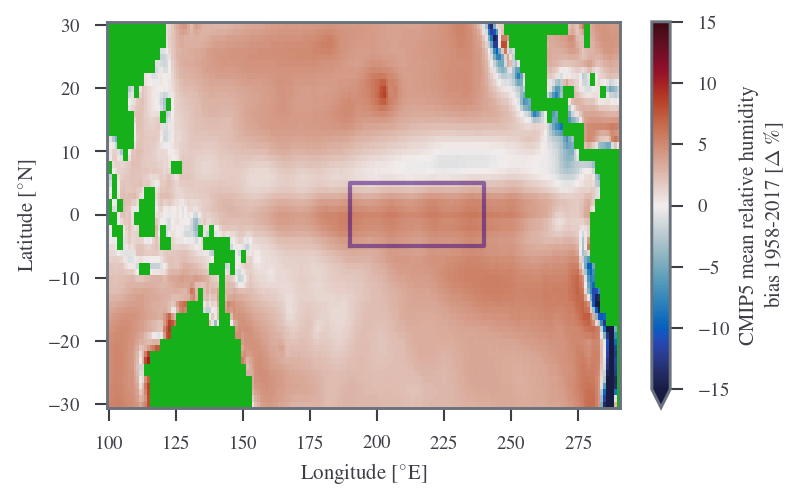

In [55]:
cmip5_rh_mean = can_coords(
    xr.open_dataarray(atmos_input_file_path(model="C", var="rh", ending="clim60"))
)
ecmwf_rh_mean = can_coords(
    xr.open_dataarray(atmos_input_file_path(var="rh", ending="clim60"))
)
cmip5_rh_mean_bias = cmip5_rh_mean.sel(Y=slice(-60, 60)) - ecmwf_rh_mean
cmip5_rh_mean_bias = clip(add_units(cmip5_rh_mean_bias))
cmip5_rh_mean_bias.attrs["units"] = r"$\Delta$ %"
cmip5_rh_mean_bias.attrs["long_name"] = "CMIP5 mean relative humidity bias 1958-2017"
cmip5_rh_mean_bias.plot(cmap=cmap("delta"), vmin=-15, vmax=15)
ax = plt.gca()
plot_nino_box(ax, reg="nino3.4", color=None)

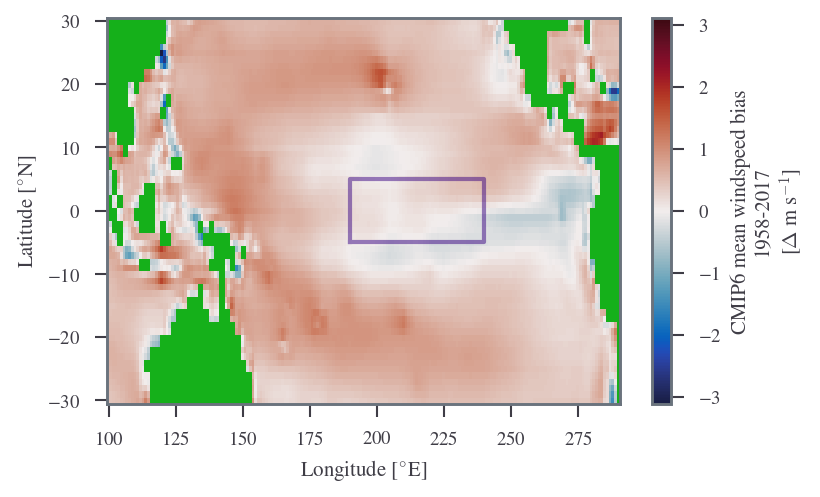

In [50]:
cmip6_wsp_mean = xr.open_dataarray(cmip6_mmm_mean("sfcWind"))
ecmwf_wsp_mean = can_coords(xr.open_dataarray(atmos_input_file_path(var="sfcWind", ending="clim60")))
cmip6_wsp_mean_bias = cmip6_wsp_mean.sel(Y=slice(-60, 60)) - ecmwf_wsp_mean
cmip6_wsp_mean_bias = clip(add_units(cmip6_wsp_mean_bias))
cmip6_wsp_mean_bias.attrs["units"] = r"$\Delta\;$m$\;$s$^{-1}$"
cmip6_wsp_mean_bias.attrs["long_name"] = "CMIP6 mean windspeed bias 1958-2017"
cmip6_wsp_mean_bias.plot(cmap=cmap("delta"))
ax = plt.gca()
plot_nino_box(
    ax, reg="nino3.4", color=None
)

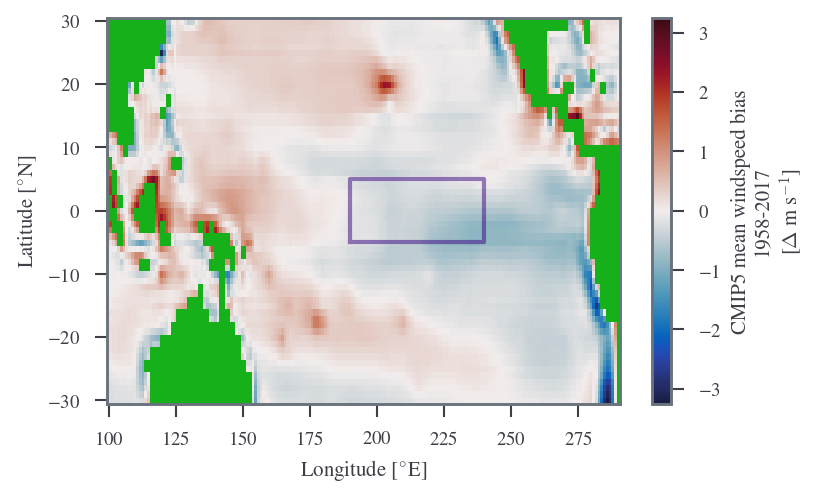

In [52]:
cmip5_wsp_mean = can_coords(
    xr.open_dataarray(atmos_input_file_path(model="C", var="sfcWind", ending="clim60"))
)
ecmwf_wsp_mean = can_coords(
    xr.open_dataarray(atmos_input_file_path(var="sfcWind", ending="clim60"))
)
cmip5_wsp_mean_bias = cmip5_wsp_mean.sel(Y=slice(-60, 60)) - ecmwf_wsp_mean
cmip5_wsp_mean_bias = clip(add_units(cmip5_wsp_mean_bias))
cmip5_wsp_mean_bias.attrs["units"] = r"$\Delta\;$m$\;$s$^{-1}$"
cmip5_wsp_mean_bias.attrs["long_name"] = "CMIP5 mean windspeed bias 1958-2017"
cmip5_wsp_mean_bias.plot(cmap=cmap("delta"))
ax = plt.gca()
plot_nino_box(ax, reg="nino3.4", color=None)

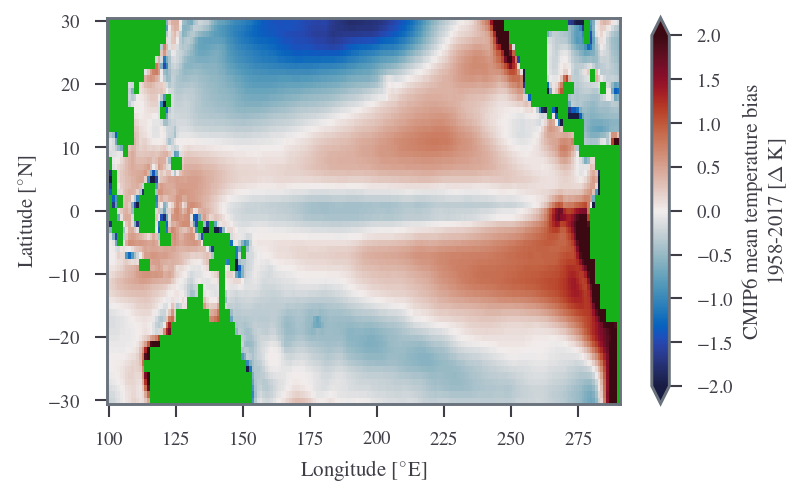

In [33]:
cmip6_ts_mean = xr.open_dataarray(cmip6_mmm_mean("ts"))
ecmwf_ts_mean = can_coords(xr.open_dataarray(atmos_input_file_path(var="ts", ending="clim60")))
cmip6_ts_mean_bias = cmip6_ts_mean.sel(Y=slice(-60, 60)) - ecmwf_ts_mean
cmip6_ts_mean_bias = clip(add_units(cmip6_ts_mean_bias))
cmip6_ts_mean_bias.attrs["units"] = r"$\Delta$ K"
cmip6_ts_mean_bias.attrs["long_name"] = "CMIP6 mean temperature bias 1958-2017"
cmip6_ts_mean_bias.plot(cmap=cmap("delta"), vmin=-2, vmax=2)

In [15]:
ecmwf_rh_mean.sel(lat=slice(-60, 60))

<xarray.DataArray 'rh' (lat: 121, lon: 360)>
array([[83.7233  , 83.71125 , 83.707184, ..., 83.80861 , 83.7656  , 83.743065],
       [83.91754 , 83.91104 , 83.91474 , ..., 83.970276, 83.93956 , 83.9275  ],
       [84.019295, 84.02017 , 84.0249  , ..., 84.021385, 84.01417 , 84.01664 ],
       ...,
       [82.275185, 82.17096 , 81.98408 , ..., 82.46049 , 82.36125 , 82.29836 ],
       [82.18216 , 81.918564, 81.58176 , ..., 82.5827  , 82.50029 , 82.345894],
       [81.979385, 81.59484 , 81.16958 , ..., 82.60367 , 82.47571 , 82.26612 ]],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 -60.0 -59.0 -58.0 -57.0 -56.0 ... 57.0 58.0 59.0 60.0
Attributes: (12/14)
    gribNumBits:         16
    grib_name:           td2m
    PDS_TimeRange:       123
    process:             255
    units:               unitless
    calendar:            standard
    ...                  ...
    PTVersion:           128
    gribparam:           168
    center:              European Center for Medium-Range Weather Forecasts -...
    file_missing_value:  -999
    long_name:           rh
    longname:            rh

In [54]:
?cmip6_ts_trend_bias.plot

# Old Figure Generation

In [ ]:
ts_mmm = sel(can_coords(xr.open_dataarray(cmip6_mmm_mean("ts")), reg="pac")

In [9]:
ts_ensemble = sel(can_coords(load_mfds(cmip6_ensemble_var("ts"), "ts")).ts, reg="pac")

warning, not changing:  member


In [10]:
ts_ensemble

,Array,Chunk
Bytes,5.17 GiB,85.33 MiB
Shape,"(62, 1920, 61, 191)","(1, 1920, 61, 191)"
Count,310 Tasks,62 Chunks
Type,float32,numpy.ndarray


In [6]:
ts_nino34_ensemble = spatial_mean(sel(ts_ensemble, reg="nino3.4")).compute()

In [7]:
ts_nino34_mean = ts_nino34_ensemble.mean("member").compute()

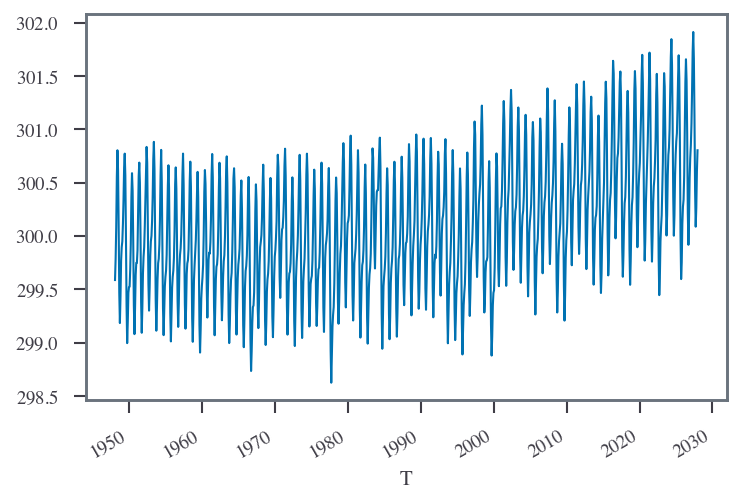

In [8]:
ts_nino34_mean.plot()

In [31]:
ts_nino34_mean_trend = get_trends(ts_nino34_mean)#.sel(T=slice("1958", "2017"))

In [32]:
ts_nino34_ensemble_trend = get_trends(ts_nino34_ensemble)

In [10]:
def get_trends(da: xr.DataArray, beginning=2007, finish=2017) -> xr.Dataset:
    da_tr_list = []
    for start, end in [(str(x - 59), str(x)) for x in range(beginning, finish+1)]:
        da_tr_list.append(
            get_trend(da.sel(T=slice(start, end)), keep_ds=True).expand_dims({"end_year": [int(end)]})
        )
    da_tr = xr.merge(da_tr_list)
    da_tr.end_year.attrs["long_name"] = "End year"
    da_tr.rise.attrs["units"] = "K"
    da_tr.rise.attrs["long_name"] = "Trend over 60 years up to end year"
    return da_tr

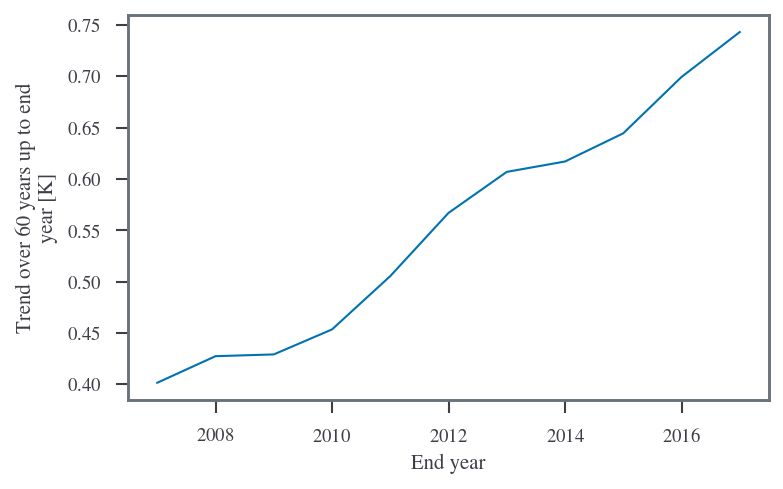

In [15]:
ts_nino34_mean_trend.rise.plot()

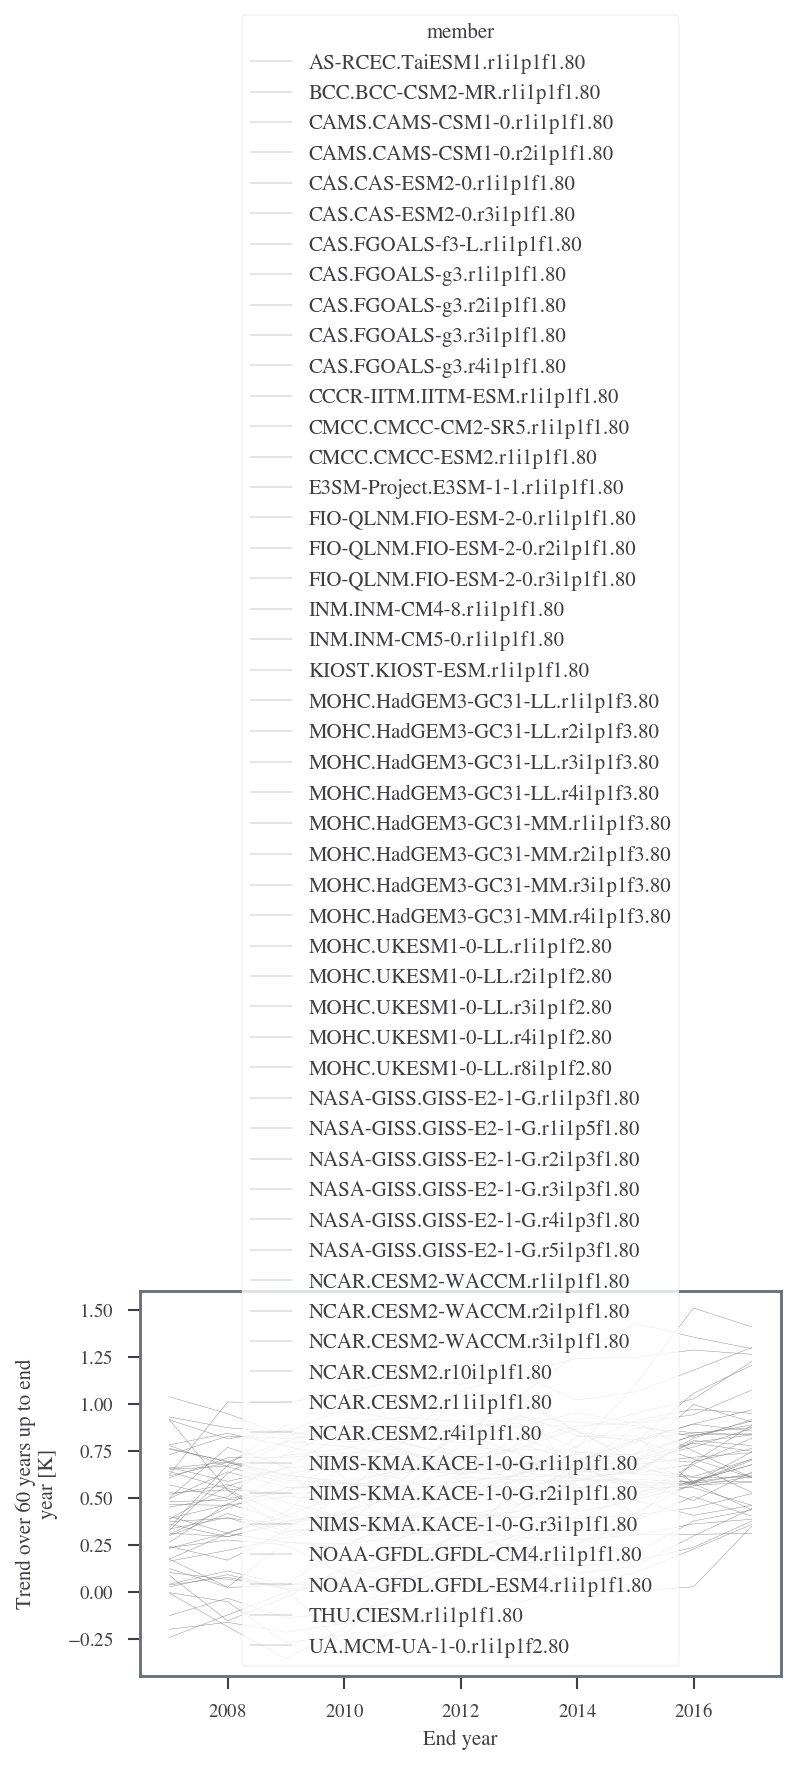

In [14]:
ts_nino34_ensemble_trend.rise.plot.line(hue="member", color="grey", linewidth=0.2)

In [ ]:
# da_tr_ensemble = get_trends(ts_ensemble)

In [28]:
ts_tr_mean = get_trends(ts_ensemble.mean("member"), beginning=2016, finish=2017).compute() - ts_trend_ecmwf

In [29]:
ts_tr_mean.rise.attrs["units"] = "$\Delta$K"
ts_tr_mean.rise.attrs["long_name"] = "$T_s$ Trend bias"

In [ ]:
ts_tr_mean.isel(end_year=1).rise.plot(cmap="cmo.balance", vmin=-2, vmax=2)

In [ ]:
rh_mmm = sel(
    can_coords(xr.open_mfdataset(cmip6_ensemble_var("hur") + "/*.nc")).hur, reg="pac"
).sel(T=slice("1958", "2017")).mean("T").mean("member").compute()

In [ ]:
sfcWind_mmm = sel(
    can_coords(xr.open_mfdataset(cmip6_ensemble_var("hur") + "/*.nc")).hur, reg="pac"
).sel(T=slice("1958", "2017"))

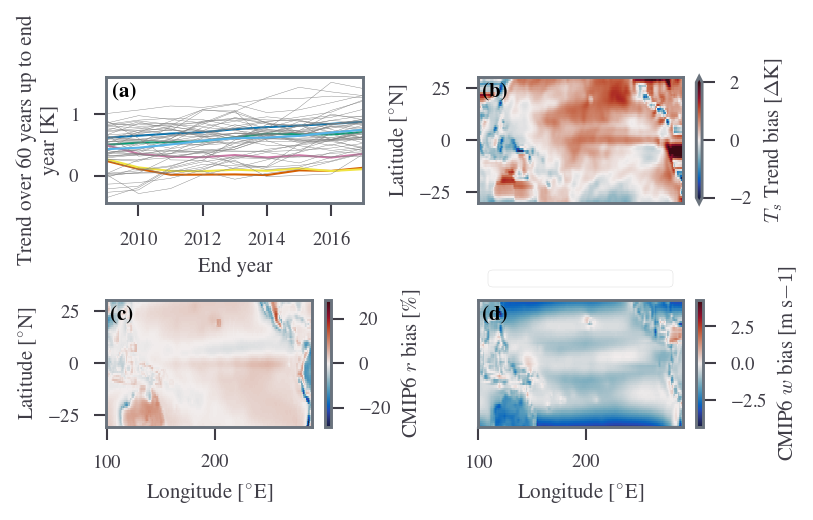

In [33]:
fig, axs = plt.subplots(2, 2)
da = xr.open_dataarray("temp.nc")
ts_trend_labels = da.plot.line(ax=axs[0, 0], hue="source")
ts_nino34_ensemble_trend.rise.plot.line(
    ax=axs[0, 0], hue="member", color="grey", linewidth=0.2
)
ts_nino34_mean_trend.rise.plot(ax=axs[0, 0])
axs[0, 0].set_xlim(2009, 2017)
ts_tr_mean.isel(end_year=1).rise.plot(ax=axs[0, 1], cmap="cmo.balance", vmin=-2, vmax=2)
axs[0, 1].set_title("")
axs[0, 1].set_xlabel("")
axs[0, 1].set_xticks([])
# da_tr_mean.isel(end_year=1).rise.plot(ax=axs[0,1], cmap="cmo.balance", vmin=-2, vmax=2)
add_units(bias_rh).plot(ax=axs[1, 0], cmap="cmo.balance")  # , vmin=0, vmax=100)
add_units(bias_wsp).plot(ax=axs[1, 1], cmap="cmo.balance")  # , vmin=0, vmax=100)
axs[1, 1].set_yticks([])
axs[1, 1].set_ylabel("")
axs[0, 0].get_legend().remove()
label_subplots(axs)
plt.legend(
    ts_trend_labels,
    bbox_to_anchor=(-0, 1.02, 1, 0.102),
    loc="lower left",
    mode="expand",
    ncol=2,
)
plt.tight_layout()

In [ ]:
rh_mmm

In [19]:
from src.constants import atmos_input_file_path

In [22]:
def get_pac(var="ts", model="E", ending="clim60"):
    return sel(
        can_coords(
            xr.open_dataarray(
                atmos_input_file_path(var=var, model=model, ending=ending)
            )
        ),
        reg="pac",
    )

In [25]:
bias_ts = get_pac(var="ts", model="S") - get_pac(var="ts", model="E")
bias_ts.attrs["units"] = "$\Delta$ K"
bias_ts.attrs["long_name"] = "CMIP6 $T_s$ bias"

In [26]:
bias_wsp = get_pac(var="sfcWind", model="S") - get_pac(var="sfcWind", model="E")
bias_wsp.attrs["units"] = "m s$-1$"
bias_wsp.attrs["long_name"] = "CMIP6 $w$ bias"

In [27]:
bias_rh = get_pac(var="rh", model="S") - get_pac(var="rh", model="E")
bias_rh.attrs["units"] = "%"
bias_rh.attrs["long_name"] = "CMIP6 $r$ bias"

In [ ]:
bias_rhC = get_pac(var="rh", model="C") - get_pac(var="rh", model="E")
bias_rhC.attrs["units"] = "%"
bias_rhC.attrs["long_name"] = "CMIP5 $r$ bias"
bias_rhC.plot()

In [ ]:
bias_rh.plot()

In [ ]:
bias_wsp.plot()

In [ ]:
bias_wspC = get_pac(var="sfcWind", model="C") - get_pac(var="sfcWind", model="E")
bias_wspC.attrs["units"] = "m s$-1$"
bias_wspC.attrs["long_name"] = "CMIP5 $w$ bias"
bias_wspC.plot()

In [ ]:
xr.open_dataarray(atmos_input_file_path(model="S"))

In [ ]:
ls /home/users/sithom/seager19/atmos/DATA/

In [24]:
ts_trend_ecmwf = get_pac(var="ts", model="E", ending="trend")